BER: 0.00012 (12/100000)


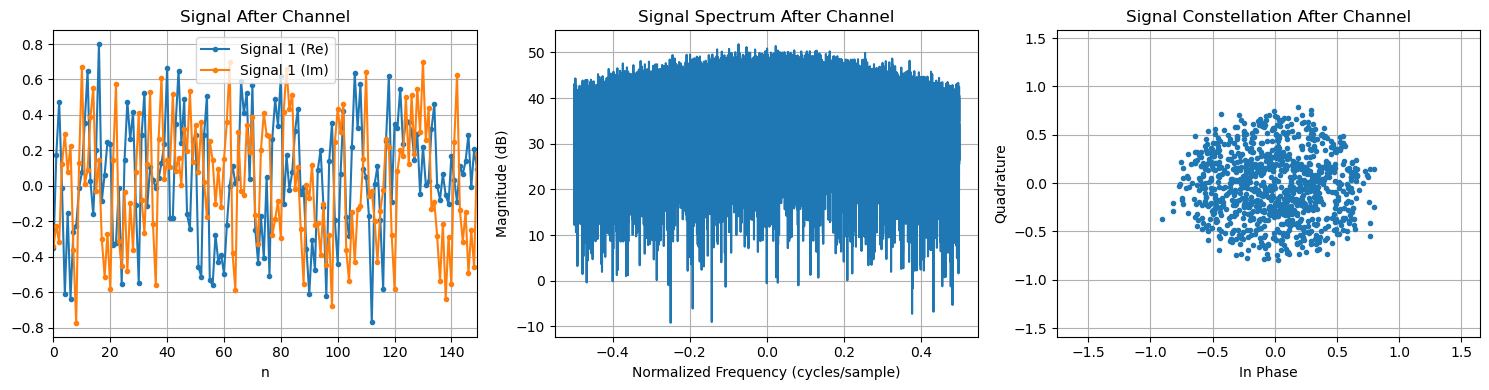

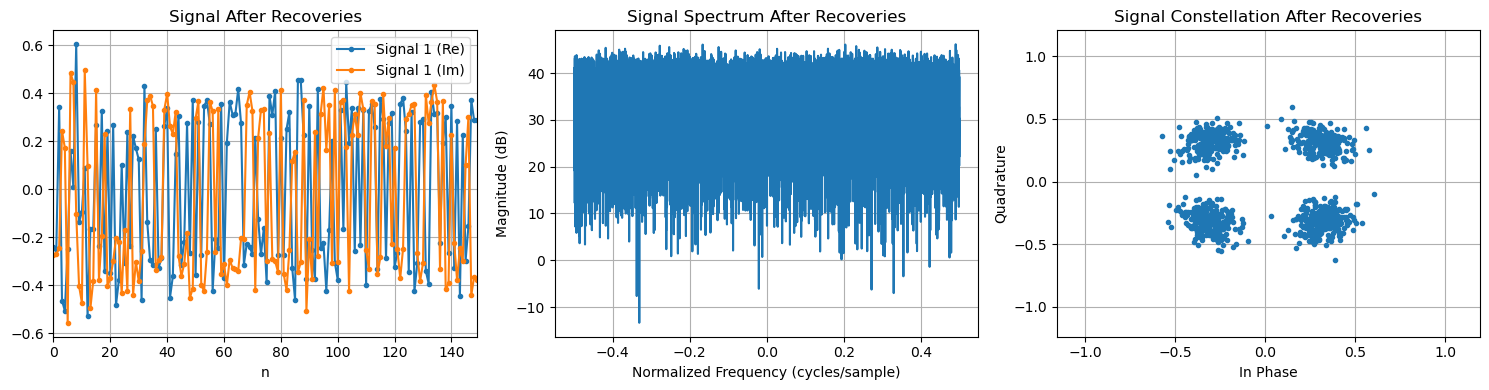

In [11]:
%reload_ext autoreload
%autoreload 2

import py_utils as pu
import numpy as np

# Example: Generate QPSK symbols
N_BITS = 10**5

bits_tx = np.random.randint(2, size=N_BITS)
sym_tx = pu.modulation.modulate_qpsk(bits_tx)


# Example: Upsample and RRC filter
SPS = 2
N_RRC_TAPS = SPS*10 + 1
sym_tx = pu.dsp.upsample(sym_tx, SPS)
sym_tx = pu.dsp.rrc_filter(sym_tx, N_RRC_TAPS, SPS)


# Example: Pass through channel
SNR_DB = 10     # dB SNR
CFO_PCT = 0.01  # 1% CFO
STO = 0.3       # fractional symbol offset

sig_chan = pu.channel.apply_cfo(sym_tx, CFO_PCT)
sig_chan = pu.channel.apply_sto(sig_chan, STO)
sig_chan = pu.channel.apply_awgn(sig_chan, SNR_DB)

sig_rx = sig_chan


# Example: Matched filter
sig_matched = pu.dsp.rrc_filter(sig_rx, N_RRC_TAPS, SPS)


# Example: Recover Sample Timing
stc = pu.timing_recovery.GardnerSymbolTimingCorrector()
symbols_sampled = stc.correct_batch(sig_matched)

# Example: Recover Carrier Frequency/Phase
K_p = 0.04
K_i = 0.03

control = pu.PIDFeedback(K_p, K_i)
sym_rot = pu.carrier_recovery.costas_loop(symbols_sampled, control)

# Example: Decode QPSK symbols
bits_rx = pu.modulation.demodulate_qpsk(sym_rot)

# Example: Compute BER
ber, n_err = pu.metrics.compute_er(bits_tx, bits_rx)
print(f'BER: {ber} ({n_err}/{N_BITS})')

# Example: Plot signal before and after recoveries
from py_utils import visualization as vz

vz.visualize(
    sig_rx, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'Signal After Channel', 'n_samps': 150}, 
        'frequency': {'title': 'Signal Spectrum After Channel'},
        'constellation': {'title': 'Signal Constellation After Channel'}
    }
);

vz.visualize(
    sym_rot, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'Signal After Recoveries', 'n_samps': 150}, 
        'frequency': {'title': 'Signal Spectrum After Recoveries'},
        'constellation': {'title': 'Signal Constellation After Recoveries'}
    }
);
